# Cómo digitalizar vídeos con Blender

Blender es un programa de animación 3D con múltiples posibilidades. Una de ellas es que dispone de una herramienta de tracking o digitalización de puntos de forma automática que funciona muy bien. Se pueden exportar archivos con las coordenadasde los marcadores digitalizados y utilizarlos para calcular los parámetros DLT y obtener coordenadas reales.

Marco de calibración:
Si están separados en varios vídeos, juntarlos en uno mismo con VirtualDub (si no, supongo que también se podría digitalizar por separado y juntar después con software).

En Blender, entrar en el modo Motion Tracking. Abrir el vídeo. Crear marcadores (botón Add a la izquierda), nombrarlos e ir realizando el tracking.

Una vez terminada la digitalización, meterse en el modo Scripting. Abrir el script de Python 
F:\Programas\Biomecanica\AnalisisImagen\Blender\PruebaTrackMarcadores\ExportarCoordenadasMarcadores-Adaptado.py


A continuación se incluye el script que se debe ejecutar desde el propio Blender:

In [ ]:
"""
Exporta las coordenadas de marcadores digitalizados con Blender
Hay que ejecutarlo desde el editor Scripting de Blender con el vídeo digitalizado abierto.
Jose Luis Lpoez Elvira
Fecha: 21/05/2018

Adaptado de :
# http://scummos.blogspot.cz/2012/11/blender-exporting-camera-tracking.html
# https://gist.github.com/anonymous/31c915d611f0a84e5d33
"""

from __future__ import print_function
import bpy
import numpy as np

D = bpy.data

unidadDisco = 'F:'
carpetaOriginal = r'\Programas\Biomecanica\AnalisisImagen\Blender\PruebaTrackMarcadores'

frameNums = True  # incluye num frames en el archivo
relativeCoords = False  # marker coords will be relative to the dimensions of the clip

#CARGA LOS DATOS DE COORDENADAS
for clip in D.movieclips:
    print('\nProcesando video {}'.format(clip.name))
    
    markers = {}
    marcadores = {} #guarda los datos de cada marcador
    nomMarcadores = []
    nomVideo = clip.name.split('.')[0]
    
    if relativeCoords:
        width = 1
        height = 1
    else:
        width = clip.size[0]
        height = clip.size[1]
    for ob in clip.tracking.objects:
        print('Procesando objeto {}'.format(ob.name))
        
        for track in ob.tracks:
            fn = '{}_{}_{}'.format(clip.name.split('.')[0], ob.name, track.name)
            markers[fn] = []
            marcadores[track.name] = []
            print('Marcador {} encontrado'.format(track.name))
            nomMarcadores.append(track.name)
            for framenum in range(clip.frame_duration):
                markerAtFrame = track.markers.find_frame(framenum)
                if markerAtFrame:
                    coords = list(markerAtFrame.co.xy)
                    coords = [coords[0] * width, coords[1] * height]
                    markers[fn].append(coords)
                    marcadores[track.name].append(coords)
                else: #si no está digitalizado este fotograma, lo deja en blanco. Es necesario para que no meta todas las filas juntas saltando huecos.
                    markers[fn].append(['', ''])
                    marcadores[track.name].append(['', ''])
                         
            
    #nomMarcadores=list(marcadores.keys())
    
    #print(len(marcadores), len(marcadores[nomMarcadores[0]]))
    #print(marcadores[nomMarcadores[0]])

    ##############################
    #ESCRIBE LOS DATOS DE TODOS LOS MARCADORES EN UN MISMO ARCHIVO
    print(len(marcadores))
    if len(marcadores) !=0:
        print('\nEscribiendo datos...')
        nombreArchivo= unidadDisco+carpetaOriginal + '\\'+nomVideo+ '_Marcadores.csv'
        with open(nombreArchivo, 'w', newline='') as writer:
            #Escribe el encabezado
            encabezado=''
            if frameNums: encabezado+='frame,'
            for h in range(len(marcadores)):
                encabezado+='{},{},'.format(str(nomMarcadores[h])+'_x', str(nomMarcadores[h])+'_y')
                print('Marcador{}, con {} frames.'.format(nomMarcadores[h], len(marcadores[nomMarcadores[h]])))
            writer.write(encabezado[:-1]+'\n')
            
            #Escribe las coordenadas
            for i in range(len(marcadores[nomMarcadores[0]])):
                linea=''
                if frameNums: linea+=str(i)+','
                for h in nomMarcadores:
                    coordx=marcadores[h][i][0]
                    coordy=marcadores[h][i][1]
                    linea+='{},{},'.format(coordx, coordy)        
                writer.write(linea[:-1]+'\n')
            
        print('Terminado', nomVideo)            
    else:
        print('\nEl video {} no tiene marcadores.'.format(nomVideo))

## Cálculo de la DLT

Una vez tenemos los vídeos digitalizados y los archivos de las coordenadas exportados, procedemos a realizar los cálculos con Python, ya fuera del entorno Blender.

En primer lugar, importamos los módulos que necesitaremos. También importamos la función para el cálculo DLT (función de Duarte, a partir de https://www.mail-archive.com/floatcanvas@mithis.com/msg00513.html) 

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

unidadDisco = 'F:' #para facilitar la portabilidad

import sys
sys.path.insert(1, unidadDisco + r'\Programacion\Python\Mios\Functions') #acceso a la carpeta donde tenemos el archivo dlt.py con las funciones necesarias
from dlt import DLTcalib, DLTrecon


Ajustamos los nombres de la carpeta donde se encuentran los archivos a tratar.

In [82]:
carpetaOriginal = r'\Programas\Biomecanica\AnalisisImagen\Blender\PruebaTrackMarcadores'
nomArchMCReal = '\Salto-MCReal.csv' #archivo con las coordenadas reales del marco de calibración
nomArchMCDigit = '\MCCompleto_Marcadores.csv' #archivo con las coordenadas digitalizadas del marco de calibración
nomMarcadoresDigit = '\CIMG1187_Marcadores.csv' #archivo con las coordenadas digitalizadas de los marcadores
separador= ','

Cargamos el archivo con las coordenadas reales de marco de calibración.

In [83]:
MCReal = pd.read_table(unidadDisco+carpetaOriginal+nomArchMCReal, sep=separador) #con values lo pasa directamente a array de numpy

El archivo tiene esta estructura:

In [84]:
MCReal

,x,y
0,0,0
1,0,100
2,40,0
3,40,100


Para funcionar con las funciones del DLT necesitamos solo el array numpy, por lo que es mejor cargarlo de esta forma:

In [85]:
MCReal = pd.read_table(unidadDisco+carpetaOriginal+nomArchMCReal, sep=separador).values #con values lo pasa directamente a array de numpy
MCReal

array([[  0,   0],
       [  0, 100],
       [ 40,   0],
       [ 40, 100]], dtype=int64)

Para visualizar el marco de calibración.

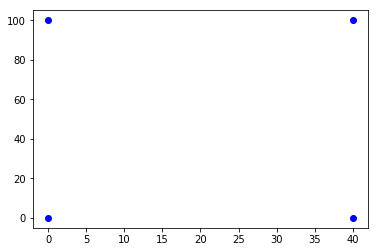

In [86]:
plt.plot(MCReal[:,0], MCReal[:,1], 'bo')
plt.show()

Cargamos el archivo con las coordenadas digitalizadas del marco de calibración. Lo hacemos en varios pasos.

In [87]:
MCDigit = pd.read_table(unidadDisco+carpetaOriginal+nomArchMCDigit, header= 0, sep=separador, na_values=[' ']) #este sin values para que haga fácil las conversiones

Normalmente en los archivos del marco de calibración se digitalizan solo unos pocos fotogramas por marcador, por lo que el archivo está lleno de valores vacíos. Para ver solo las coordenadas, podemos eliminar los valores nan (not a number). Aunque esto no es necesario porque a continuación calcularemos la media de cada marcadore en los fotogramas digitalizados.

In [88]:
MCDigit.iloc[:, 1:].dropna(how='all')

,InfIzq_x,InfIzq_y,SupIzq_x,SupIzq_y,InfDer_x,InfDer_y,SupDer_x,SupDer_y
398,207.256989,17.638893,204.107178,336.398872,NaN,NaN,NaN,NaN
400,207.550690,19.553613,NaN,NaN,NaN,NaN,NaN,NaN
401,207.550690,19.306552,NaN,NaN,NaN,NaN,NaN,NaN
433,207.110138,19.306552,NaN,NaN,NaN,NaN,NaN,NaN
602,NaN,NaN,NaN,NaN,311.830414,19.371284,308.995575,335.926392
603,NaN,NaN,NaN,NaN,311.830414,19.433048,309.582977,336.049919
604,NaN,NaN,NaN,NaN,311.830414,19.433048,NaN,NaN


Se calcula el promedio de cada marcador en todos los fotogramas en los que se haya digitalizado y se ordena para que quede con estructura de los marcadores en filas y las coordenadas x e y en columnas.

In [89]:
#hay que transformar la estructura de filas-frames, columnas marcadores con x e y, a filas-marcadores, columnas x e y
MCDigit = MCDigit.iloc[:, 1:].mean().T #quita columna frames, hace media de cada columna y la transpone
MCDigit =np.asarray([MCDigit[::2], MCDigit[1::2]]).T #mete en un array las medias de x y de y y las transpone

El archivo tiene esta estructura:

In [90]:
MCDigit

array([[ 207.36712646,   18.95140243],
       [ 204.10717773,  336.39887238],
       [ 311.83041382,   19.41245985],
       [ 309.28927612,  335.98815536]])

Finalmente se cargan las coordenadas de los marcadores digitalizados. Posiblemente los primeros fotogramas salgan vacíos de datos, esto es porque las digitalizaciones empiezan más tarde.

In [91]:
MarcadoresDigit = pd.read_table(unidadDisco+carpetaOriginal+nomMarcadoresDigit , header= 0, sep=separador, na_values=[' '])
MarcadoresDigit.head()

,frame,Cadera_x,Cadera_y,Rodilla_x,Rodilla_y,Tobillo_x,Tobillo_y,Talon_x,Talon_y,Meta_x,Meta_y
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Como después nos vendrá bien, nos quedamos con los nombres de los marcadores

In [92]:
nomMarcadores = [x[:-2] for x in MarcadoresDigit.iloc[:, 1::2].columns] #se queda con el nombre de los marcadores
nomMarcadores

['Cadera', 'Rodilla', 'Tobillo', 'Talon', 'Meta']

Para poder operar con las funciones del DLT, se quita la primera columna (frames) y se deja como array de numpy.

In [93]:
MarcadoresDigit = MarcadoresDigit.iloc[:, 1:].values #quita columna frames y lo hace numpy

Para ver las coordenadas de los marcadores digitalizados, en series temporales y como plano:

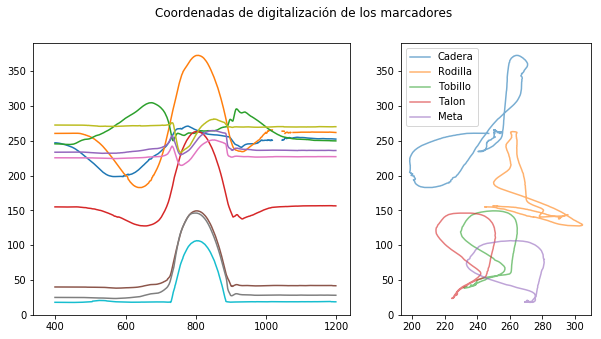

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), gridspec_kw = {'width_ratios':[2.5, 1.5]})
ax[0].plot(MarcadoresDigit)

for h in range(0, MarcadoresDigit.shape[1], 2):
    ax[1].plot(MarcadoresDigit[:,h], MarcadoresDigit[:,h+1], alpha=0.6, label='{}'.format(nomMarcadores[h//2]))
ax[1].legend()

plt.suptitle('Coordenadas de digitalización de los marcadores')
plt.show()

## Empieza a calcular el DLT

In [95]:
nd=2 #nº dimensiones
nc=1 #nº cámaras

#calcula parámetros de calibración
L1, err1 = DLTcalib(nd, MCReal, MCDigit)

#Reconstruye las coordenadas punto por punto
MarcadoresReconst = np.zeros((len(MarcadoresDigit), MarcadoresDigit.shape[1]))
for h in range(0, MarcadoresDigit.shape[1], 2):
    for i in range(len(MarcadoresDigit)):
        MarcadoresReconst[i, h:h+2] = DLTrecon( nd, nc, L1, MarcadoresDigit[i, h:h+2])

Finalmente muestra las coordenadas reconstruidas junto con los marcadores reales del marco de calibración. 

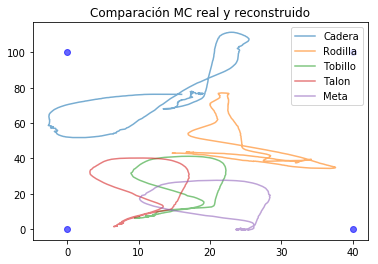

In [96]:
fig, ax = plt.subplots() 
plt.plot(MCReal[:,0], MCReal[:,1], 'bo', alpha=0.6)
for h in range(0, MarcadoresReconst.shape[1], 2):
    plt.plot(MarcadoresReconst[:,h], MarcadoresReconst[:,h+1], alpha=0.6, label='{}'.format(nomMarcadores[h//2]))
plt.legend()
plt.title('Comparación MC real y reconstruido')
plt.show()